<a href="https://colab.research.google.com/github/efekoyuncu/StjBackend/blob/main/InsiderCaseStudyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSIDER CASE STUDY - EFE KOYUNCU

Load and Explore the Dataset

 Read and Correct Lines Programmatically

     id                                           category  \
0   116                           TELEKOM > AKILLI TELEFON   
1   462             Bilgisayar > Taşınabilir Bilgisayarlar   
2  1300           Ev Elektroniği > Televizyonlar > SAMSUNG   
3  1665  Bilgisayar > Bilgisayar Parçaları > Monitör > ...   
4  2021                                Cep Telefonu > Sony   

                                         description  
0                                                NaN  
1  HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...  
2  ÖZELLİKLER Ekran Ekran Boyutu 48" Ekran Boyutu...  
3  Ürün Kodu : 40061255166 Genel Özellikler Panel...  
4                                                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1450 non-null   int64 
 1   category     1429 non-null   object
 2   description  1150 non-

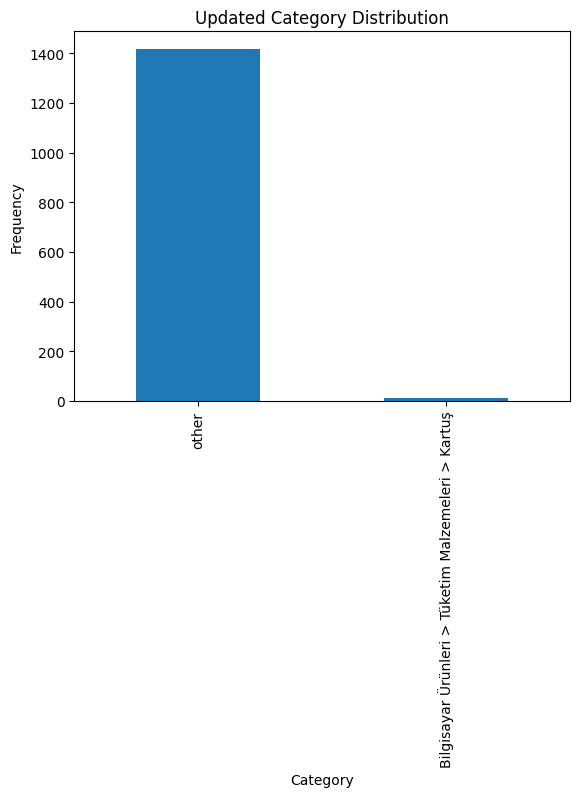

id               0
category        21
description    300
dtype: int64


<ipython-input-5-91b54c3d429f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'] = data['category'].str.replace('>', ' > ')


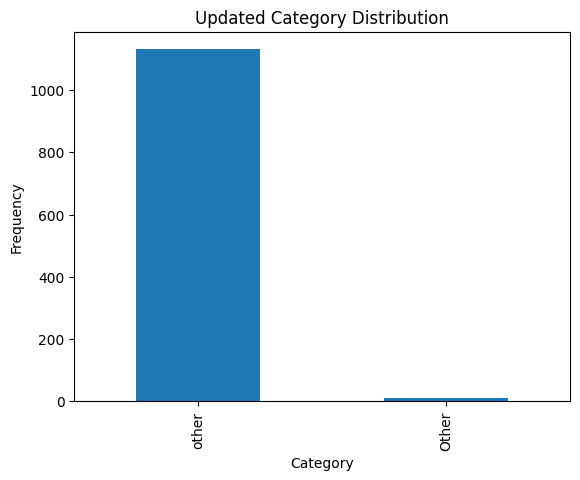

Gradient Boosting Report:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       1.00      0.96      0.98       227

    accuracy                           0.97       229
   macro avg       0.60      0.98      0.66       229
weighted avg       0.99      0.97      0.98       229

[[  2   0]
 [  8 219]]
XGBoost Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       1.00      0.97      0.99       227

    accuracy                           0.97       229
   macro avg       0.62      0.99      0.69       229
weighted avg       0.99      0.97      0.98       229

[[  2   0]
 [  6 221]]
Best Parameters for XGBoost:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Improved Model Report:
              precision    recall  f1-score   support

           0       0.11      1.00      0.19         2
           1 

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib
from flask import Flask, request, jsonify

# Step 1: Load and Explore Dataset
categories = pd.read_csv('/content/Product_Categories.txt', sep=';', header=None, names=['id', 'category'], on_bad_lines='skip')
descriptions = pd.read_csv('/content/Product_Explanation.txt', sep=';', header=None, names=['id', 'description'], on_bad_lines='skip')
data = pd.merge(categories, descriptions, on='id')
print(data.head())
print(data.info())
print(data['category'].value_counts())

# Group rare categories into 'Other'
threshold = 10
category_counts = data['category'].value_counts()
rare_categories = category_counts[category_counts < threshold].index
data['category'] = data['category'].apply(lambda x: 'other' if x in rare_categories else x)

# Visualize the updated category distribution
data['category'].value_counts().plot(kind='bar')
plt.title('Updated Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Step 2: Handle Missing or Inconsistent Data
print(data.isnull().sum())
data = data.dropna(subset=['description', 'category'])
data['category'] = data['category'].str.replace('>', ' > ')

# Step 3: Handle Rare Categories
threshold = 50
category_counts = data['category'].value_counts()
rare_categories = category_counts[category_counts < threshold].index
data['category'] = data['category'].apply(lambda x: 'Other' if x in rare_categories else x)

# Visualize the updated category distribution
data['category'].value_counts().plot(kind='bar')
plt.title('Updated Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Step 4: Preprocess Text Data
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1, 2))
X = vectorizer.fit_transform(data['description'])
le = LabelEncoder()
y = le.fit_transform(data['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Experiment with different undersampling ratios and SMOTE parameters
under_sampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
smote = SMOTE(sampling_strategy=1.0, random_state=42)

# Create a pipeline with undersampling and SMOTE
pipeline = Pipeline(steps=[('under', under_sampler), ('smote', smote)])

X_res, y_res = pipeline.fit_resample(X_train, y_train)


# Step 6: Experiment with Advanced Algorithms and Class Weights
model_gb = GradientBoostingClassifier()
model_gb.fit(X_res, y_res)
y_pred_gb = model_gb.predict(X_test)
print("Gradient Boosting Report:")
print(classification_report(y_test, y_pred_gb, zero_division=1))
print(confusion_matrix(y_test, y_pred_gb))

model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=10)
model_xgb.fit(X_res, y_res)
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb, zero_division=1))
print(confusion_matrix(y_test, y_pred_xgb))

# Step 7: Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 5, 10, 15]
}
grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_grid, cv=5)
grid_search.fit(X_res, y_res)
print("Best Parameters for XGBoost:")
print(grid_search.best_params_)

# Step 8: Model Evaluation and Interpretation
y_pred = grid_search.best_estimator_.predict(X_test)
print("Improved Model Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print(confusion_matrix(y_test, y_pred))

# Step 9: Save and Deploy Best Model
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

app = Flask(__name__)
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    description = data['description']
    vectorized_desc = vectorizer.transform([description])
    prediction = model.predict(vectorized_desc)
    category = label_encoder.inverse_transform(prediction)[0]
    return jsonify({'category': category})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)